In [3]:
# Import

# Basic
from time import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


---
# My Plan

My ultimate objective is to predict the probability of credit card defaults. My plan is to develop a classification algorithm, to predict if a user is going to default. Then, I can predict the probability of default based on the number of predicted default users.

1. Load data and check columns
2. Calculate the percentage of credit card defaults out of all the users
3. Explore the whole dataset and find any interesting insights. At the same time, 
    - evaluate the data quality 
    - figure out whether outliers exist
    - Clean Data
4. Perform feature engineering
5. Quick fit and Select the strongest predictors



---
# 1. Loading Credit Card User Data

In [4]:
# Load the data
df = pd.read_csv('dataset/data.csv') 
df.dtypes


ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
PAY_1                         float64
dtype: objec

---

PAY_1 is not in the data dictionary. Let's see whats in it.

In [5]:
df.PAY_1

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9995   NaN
9996   NaN
9997   NaN
9998   NaN
9999   NaN
Name: PAY_1, Length: 10000, dtype: float64

Looks like its all missing values. Let's do a quick check.

In [6]:
df.groupby(df.PAY_1.astype(str)).agg({'ID':'count'})

,ID
PAY_1,
0.0,100
nan,9900


Yes, almost all of it are missing values. 100 of them are labelled as 0 but 0 has not be defined in the data dictionary. So, there is no meaningful data in this column.

Therefore, I have decided to remove PAY_1.



In [7]:
df.drop(columns=['PAY_1'], inplace=True)
df.dtypes


ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

---
On the other hand, according to the dictionary, PAY_0 is the Repayment status in September, which is inconsistent with the labelling of BILL_AMT1 (September) and PAY_AMT1 (September). Therefore, I believe 'PAY_0' was a mislabelled. I will rename it as PAY_1.

In [8]:
# fixing the names
df = df.rename(columns={'PAY_0': 'PAY_1'})
df.dtypes



ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_1                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

---
I found the field name 'default.payment.next.month' not easy to use. Therefore, I am going to rename it as 'DEFAULT_PAY'.


In [9]:
# fixing the names
df = df.rename(columns={'default.payment.next.month': 'DEFAULT_PAY'})
df.dtypes


ID               int64
LIMIT_BAL      float64
SEX              int64
EDUCATION        int64
MARRIAGE         int64
AGE              int64
PAY_1            int64
PAY_2            int64
PAY_3            int64
PAY_4            int64
PAY_5            int64
PAY_6            int64
BILL_AMT1      float64
BILL_AMT2      float64
BILL_AMT3      float64
BILL_AMT4      float64
BILL_AMT5      float64
BILL_AMT6      float64
PAY_AMT1       float64
PAY_AMT2       float64
PAY_AMT3       float64
PAY_AMT4       float64
PAY_AMT5       float64
PAY_AMT6       float64
DEFAULT_PAY      int64
dtype: object

---
# 2. Calculate the percentage of credit card defaults out of all the users


In [10]:
df.DEFAULT_PAY.sum() / len(df.DEFAULT_PAY)


0.2238

22% of credit card user have defaulted. 

In mentioned earlier, I have to develop a classification algorithm. However, given this uneven class distribution (78% vs 22%), we have to be careful when choosing our evaluation metric. F1 is, in my knowledge, the best candidate.



---
# 3. Explore the whole dataset and find any interesting insights


In [11]:
# create a copy of df so that I could improve the labelling of categories. 
df_explore = df.copy()

---
## 3.1. Categorical data
There are Sex, Education and Marriage.


---
### Sex
Key: 1=male, 2=female


In [12]:
# relabel
df_explore['SEX'] = df_explore['SEX'].replace([1,2],['male','female'])


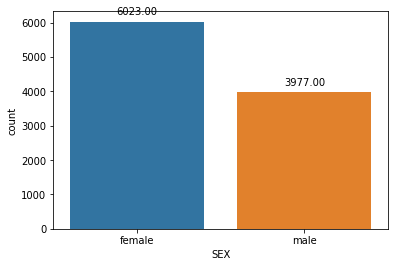

In [13]:
def bar_chart(df, col):
    ax = sns.countplot(x=col, data=df)
    
    for p in ax.patches:
        ax.annotate(\
            format(p.get_height(), '.2f'), \
            (p.get_x() + p.get_width() / 2., p.get_height()), \
            ha = 'center', va = 'center', \
            xytext = (0, 10), \
            textcoords = 'offset points')

bar_chart(df_explore, 'SEX')

    

In [14]:
def d_rate_by_col(df, col):
    d_rate = df.groupby([col, 'DEFAULT_PAY']).size().unstack()
    d_rate['perc'] = \
        (d_rate[d_rate.columns[1]]/(d_rate[d_rate.columns[0]] + d_rate[d_rate.columns[1]]))
    return d_rate

d_rate_by_col(df_explore, 'SEX')

DEFAULT_PAY,0,1,perc
SEX,,,
female,4723,1300,0.215839
male,3039,938,0.235856


There are more female than male.

Male are more likely to default than Female. 


---
### Education
Key: 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown


In [15]:
df_explore.groupby(df_explore.EDUCATION.astype(str)).agg({'ID':'count'})



,ID
EDUCATION,
0,8
1,3514
2,4585
3,1633
4,46
5,90
6,124


0 has not been defined in the data dictionary. So, I am going to group it together with 5 and 6 (both unknown).

In addition, 4 only has 46 samples. It is not going to be a strong predictor anyway so I am going to merge it with the unknown group.

In [16]:
# relabel and re-group
df_explore['EDUCATION'] = \
    df_explore['EDUCATION'].replace([0,4,5,6],'unknown_and_others')
df_explore['EDUCATION'] = df_explore['EDUCATION'].replace([1,2,3],['graduate_school','university','high_school'])


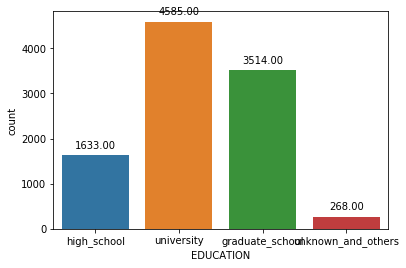

In [17]:
bar_chart(df_explore, 'EDUCATION')

In [18]:
d_rate_by_col(df_explore, 'EDUCATION')

DEFAULT_PAY,0,1,perc
EDUCATION,,,
graduate_school,2819,695,0.197780
high_school,1223,410,0.251072
university,3465,1120,0.244275
unknown_and_others,255,13,0.048507


Most users are university students. The second biggest group is graduate students.

It seems like the higher the education level (high school < university < graduate school) the lower the default rate.  


---

### Marriage
Key: 1=married, 2=single, 3=others

In [19]:
df_explore.groupby(df_explore.MARRIAGE.astype(str)).agg({'ID':'count'})


,ID
MARRIAGE,
0,13
1,4476
2,5287
3,224


0 has not been defined in the data dictionary. It only has 13 samples. So, I am going to group it with 3 (others).


In [20]:
# relabel and re-group
df_explore['MARRIAGE'] = \
    df_explore['MARRIAGE'].replace([0,3],'unknown_and_others')
df_explore['MARRIAGE'] = df_explore['MARRIAGE'].replace([1,2],['married','single'])


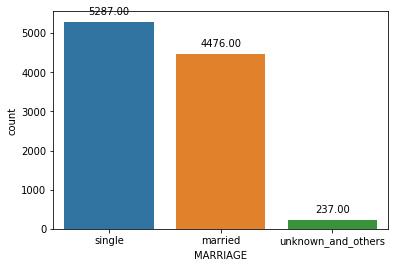

In [21]:
bar_chart(df_explore, 'MARRIAGE')

In [22]:
d_rate_by_col(df_explore, 'MARRIAGE')

DEFAULT_PAY,0,1,perc
MARRIAGE,,,
married,3393,1083,0.241957
single,4175,1112,0.210327
unknown_and_others,194,43,0.181435


Most users are single. 

Married users have higher default rate.


---

## 3.1. Continuous data
There are 
- Credit, 
- Age, 
- Repayment status in month X, 
- Amount of bill statement in month X,
- Amount of previous payment in month X.

---

### Credit


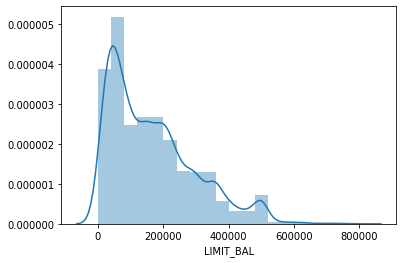

In [23]:
sns.distplot( df_explore['LIMIT_BAL'], bins=20)


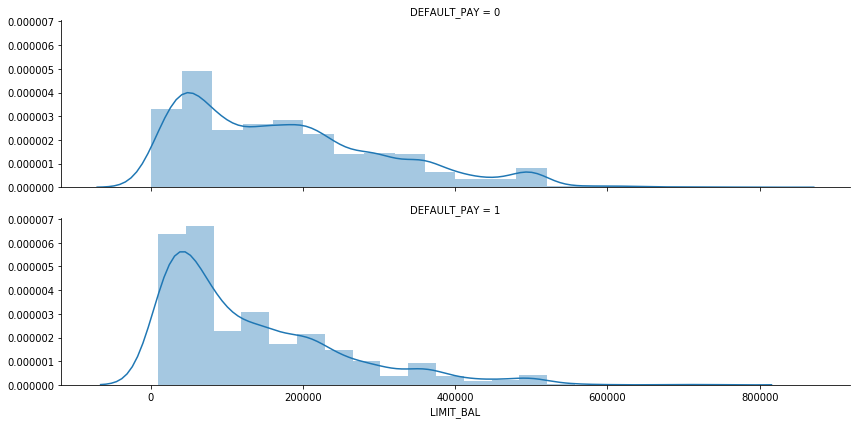

In [24]:
def def_dist(df, col, bins):
    g = sns.FacetGrid(df, row='DEFAULT_PAY',
                  height=3, aspect=4,)
    g.map(sns.distplot, col, bins=bins);

def_dist(df_explore, 'LIMIT_BAL', 20)



The distribution of credit is skewed, with a long tail of high credit users.

As expected, the most defaulted users have lower credits.

---

### Age


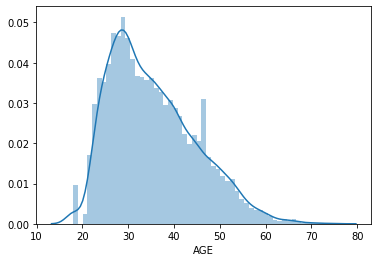

In [25]:
sns.distplot( df_explore['AGE'], bins=55)


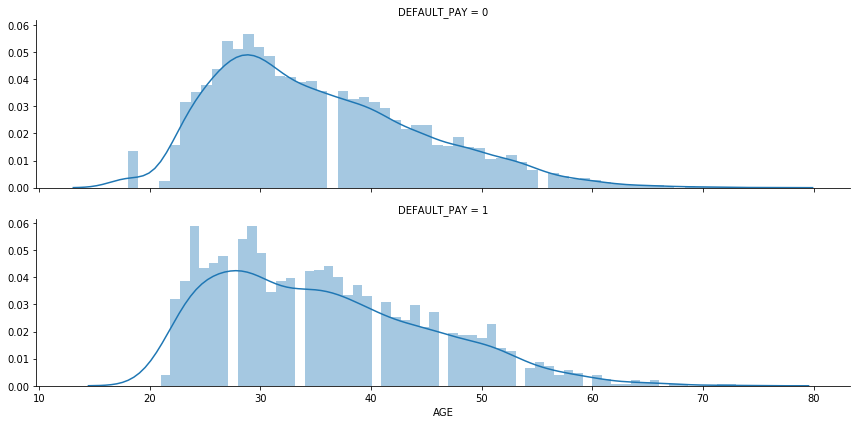

In [26]:
def_dist(df_explore, 'AGE', 60)


The distribution of age is skewed, with a long tail of older users.

The difference is not that obvious.


---

### Understanding the relationship among Bill, Payment and Repayment Status
- BILL_AMT: Amount of bill statement in XXXX
- PAY_AMT: Amount of previous payment in XXXX
- PAY: Repayment status in XXXX, (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

To understand the relationship among the factors, I have selected the items with repayment status = pay duly (i.e. -1).  


In [27]:
sel_filter = ((df.PAY_6 == -1) & (df.BILL_AMT6 > 0))
df_explore[sel_filter][['BILL_AMT6', 'PAY_AMT6', 'PAY_6', 'BILL_AMT5', 'PAY_AMT5', 'PAY_5']].sample(10)

,BILL_AMT6,PAY_AMT6,PAY_6,BILL_AMT5,PAY_AMT5,PAY_5
720,430.0,1166.0,-1,860.0,430.0,-1
123,2706.0,0.0,-1,0.0,2706.0,-1
9703,878.0,878.0,-1,1028.0,878.0,-1
7215,3366.0,990.0,-1,3601.0,3476.0,-1
4285,17333.0,346.0,-1,2800.0,17333.0,-1
4523,4533.0,0.0,-1,2202.0,5131.0,0
2625,5239.0,0.0,-1,16550.0,5265.0,-1
6509,1225.0,1588.0,-1,2678.0,1544.0,-1
3826,270.0,0.0,-1,3950.0,270.0,0
9309,467.0,3513.0,-1,780.0,467.0,-1


In [28]:
df_explore[sel_filter].groupby(df_explore.BILL_AMT6<=df_explore.PAY_AMT5).agg({'ID':'count'})


,ID
False,41
True,1670


In [29]:
sel_filter = ((df.PAY_5 == -1) & (df.BILL_AMT5 > 0))
df_explore[sel_filter][['BILL_AMT5', 'PAY_AMT5', 'PAY_5', 'BILL_AMT4', 'PAY_AMT4', 'PAY_4']].sample(10)

,BILL_AMT5,PAY_AMT5,PAY_5,BILL_AMT4,PAY_AMT4,PAY_4
1201,3158.0,9530.0,-1,3058.0,3158.0,-1
9833,3965.0,8676.0,-1,0.0,3965.0,-2
8790,1207.0,1207.0,-1,1207.0,1207.0,-1
1243,10986.0,5081.0,-1,4932.0,10986.0,-1
7791,3786.0,1916.0,-1,2404.0,3786.0,-1
5566,1216.0,4475.0,-1,1578.0,1216.0,-1
108,104160.0,0.0,-1,0.0,104160.0,0
8260,75882.0,90611.0,-1,12279.0,75882.0,-1
4495,3079.0,4095.0,-1,8413.0,3093.0,-1
1907,15011.0,2000.0,-1,-192.0,16350.0,-1


In [30]:
df_explore[sel_filter].groupby(df_explore.BILL_AMT5<=df_explore.PAY_AMT4).agg({'ID':'count'})


,ID
False,33
True,1635


I can see that PAY_AMT(n) is related to BILL_AMT(n+1).



---
###  Repayment status: PAY_(n) 

Key: -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above

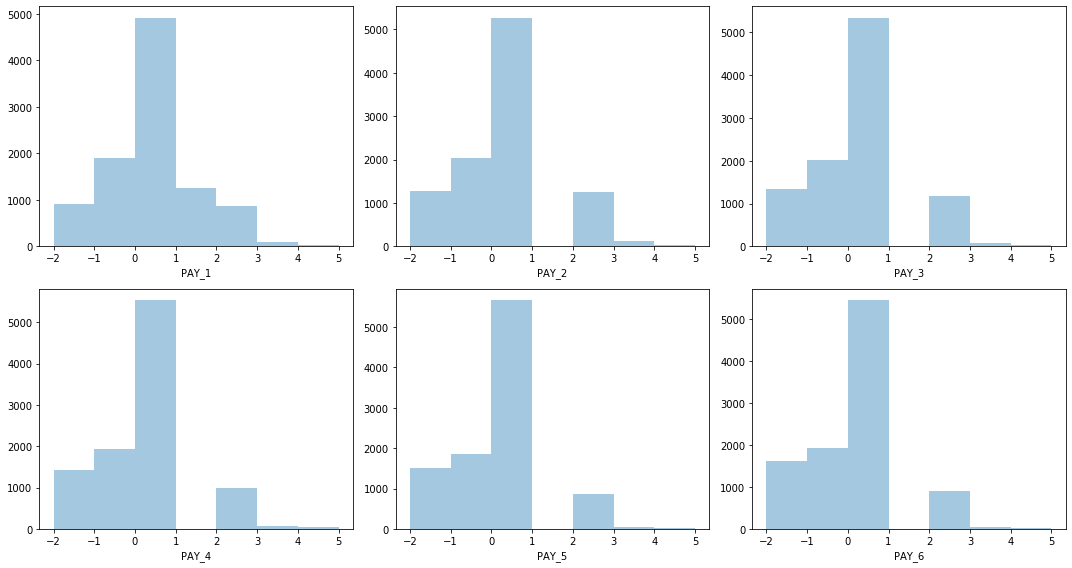

In [31]:
# plot the histogram of the payment
fig, axes = plt.subplots(2,3,figsize=(15,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    plt.subplot(ax)
    sns.distplot(df_explore['PAY_'+str(i+1)], bins=np.arange(-2,6), kde=False, ax=ax)
    ax.set(xlabel='PAY_'+str(i+1))

plt.tight_layout()



- Unknown: -2 and 0 are not documented in the data dictionary. Therefore, I am going to group them into 'unknown'.

- Delayed: There isn't much variation in the number of delay months, most of the months has 2 months delays. Therefore, I am going to group all 1+ month delays as 'delay'.

- Pay duly: -1 (no change).


In [32]:
select_cols = ['PAY_'+str(i) for i in range(1,7)]
df_explore[select_cols] = df_explore[select_cols].replace([-2,0],'unknown')
df_explore[select_cols] = df_explore[select_cols].replace(np.arange(1,10),'delayed')
df_explore[select_cols] = df_explore[select_cols].replace(-1,'pay_duly')



In [33]:
d_rate_by_col(df_explore, 'PAY_1')


DEFAULT_PAY,0,1,perc
PAY_1,,,
delayed,1126,1152,0.505707
pay_duly,1596,302,0.159115
unknown,5040,784,0.134615


In [34]:
d_rate_by_col(df_explore, 'PAY_2')


DEFAULT_PAY,0,1,perc
PAY_2,,,
delayed,644,790,0.550907
pay_duly,1715,318,0.156419
unknown,5403,1130,0.172968


As expected, the users with delayed payments are more likely to default.


---
### Amount of bill statement: BILL_AMT(n)


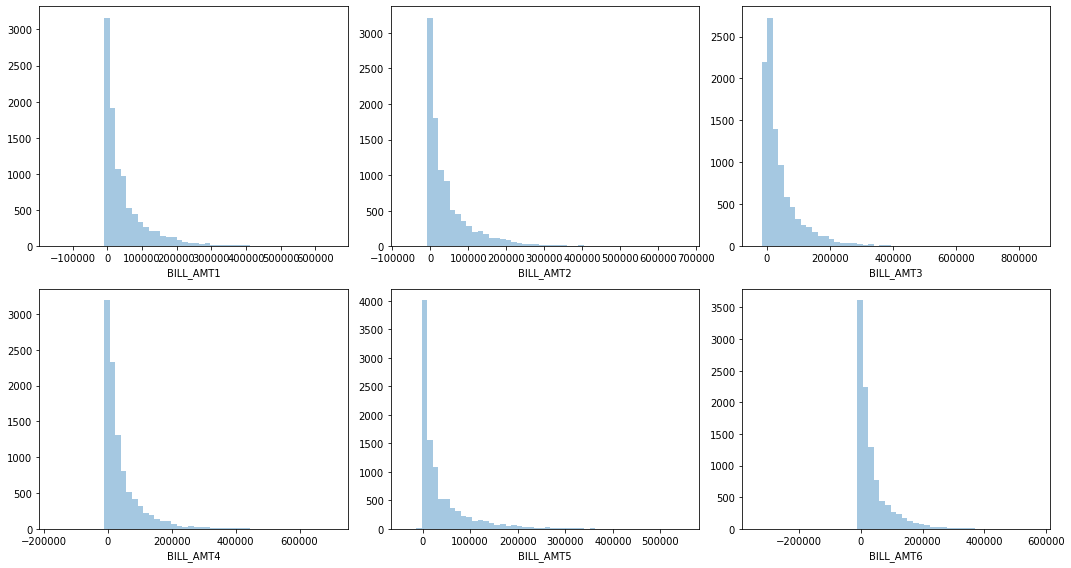

In [35]:
def monthly_plot(df, element):
    fig,axes = plt.subplots(2,3,figsize=(15,8))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        plt.subplot(ax)
        sns.distplot(df[element+str(i+1)], kde=False, ax=ax)
        ax.set(xlabel=element+str(i+1))
    
    plt.tight_layout()

monthly_plot(df_explore, 'BILL_AMT')



In [36]:
def sign(x):
    if x < 0:
        return 'negative'
    elif x == 0:
        return 'zero'
    else:
        return 'positive'

BILL_AMT1_SIGN = df_explore['BILL_AMT1'].apply(lambda x: sign(x))

df_temp = pd.DataFrame({'BILL_AMT1_SIGN': BILL_AMT1_SIGN,'DEFAULT_PAY':df_explore['DEFAULT_PAY']})

d_rate_by_col(df_temp, 'BILL_AMT1_SIGN')

DEFAULT_PAY,0,1,perc
BILL_AMT1_SIGN,,,
negative,149,41,0.215789
positive,7124,2018,0.220739
zero,489,179,0.267964


I found out that there are some negative billing payments, which shouldn't exist. I am going to group them into 0.

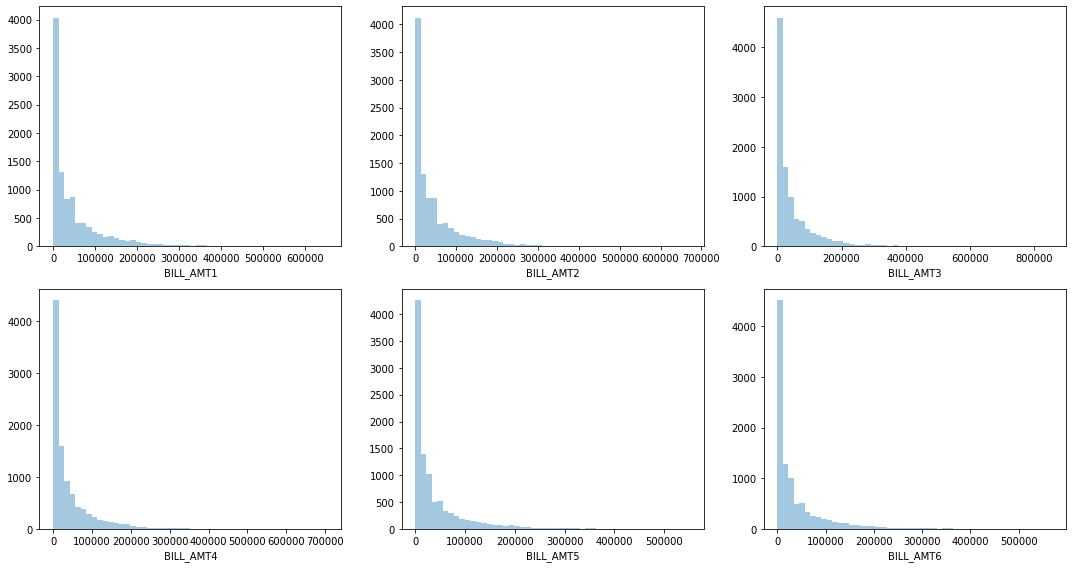

In [37]:
select_cols = ['BILL_AMT'+str(i) for i in range(1,7)]
df_explore[select_cols] = df_explore[select_cols].clip(lower=0)

monthly_plot(df_explore, 'BILL_AMT')


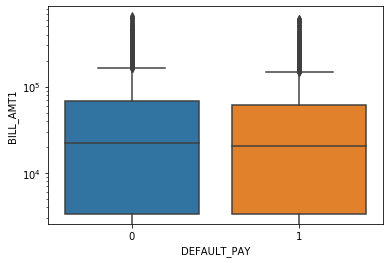

In [38]:
ax = sns.boxplot(x="DEFAULT_PAY", y="BILL_AMT1", data=df_explore)
ax.set_yscale("log")

In [39]:
BILL_AMT1_BUCK = pd.qcut(df_explore['BILL_AMT1'], 5)

df_temp = pd.DataFrame({'BILL_AMT1_BUCK': BILL_AMT1_BUCK,'DEFAULT_PAY':df_explore['DEFAULT_PAY']})

d_rate_by_col(df_temp, 'BILL_AMT1_BUCK')


DEFAULT_PAY,0,1,perc
BILL_AMT1_BUCK,,,
"(-0.001, 1696.2]",1551,449,0.2245
"(1696.2, 12590.8]",1575,425,0.2125
"(12590.8, 35648.6]",1478,522,0.2610
"(35648.6, 83010.0]",1570,430,0.2150
"(83010.0, 653062.0]",1588,412,0.2060


Users with billing statement between 12590.8 and 35648.6 has the highest default rate.

---
### Amount of previous payment: PAY_AMT(n)

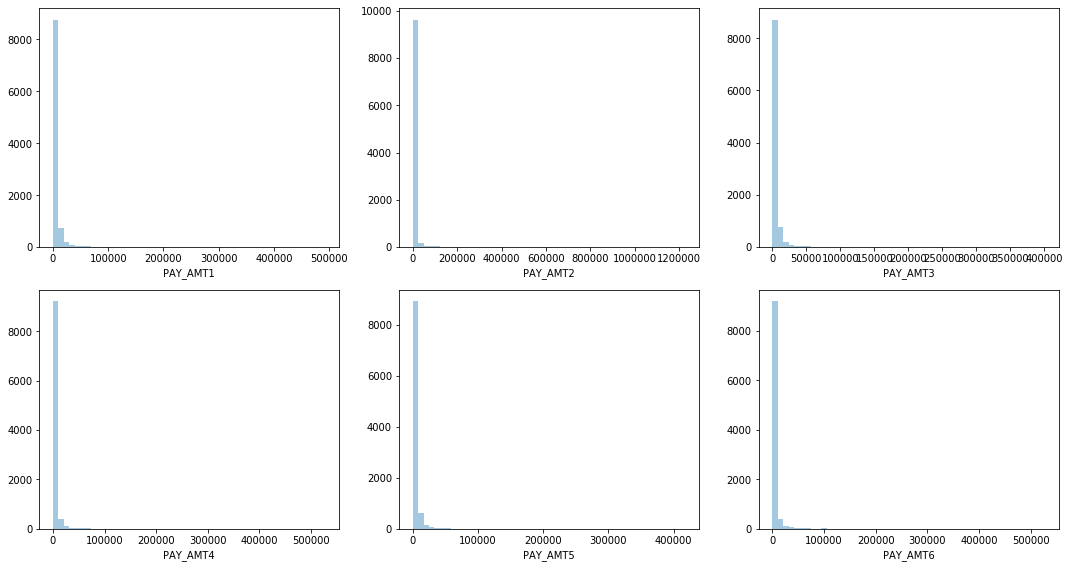

In [40]:
monthly_plot(df_explore, 'PAY_AMT')


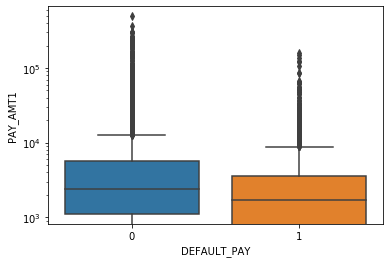

In [41]:
ax = sns.boxplot(x="DEFAULT_PAY", y="PAY_AMT1", data=df_explore)
ax.set_yscale("log")

Default users pay a lot less than the other users.

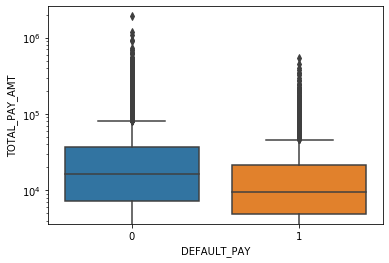

In [42]:
select_cols = ['PAY_AMT'+str(i) for i in range(1,7)]
TOTAL_PAY_AMT = df_explore[select_cols].sum(axis=1)

df_temp = pd.DataFrame({'TOTAL_PAY_AMT': TOTAL_PAY_AMT,'DEFAULT_PAY':df_explore['DEFAULT_PAY']})

ax = sns.boxplot(x="DEFAULT_PAY", y="TOTAL_PAY_AMT", data=df_temp)
ax.set_yscale("log")

---
# 4. Baseline Model


---

## One-hot Encoding for categorical data
Transforming Categorical Data


In [43]:
onehot_names = ['SEX','EDUCATION','MARRIAGE']+['PAY_'+str(i) for i in range(1,7)]
onehot_names

['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

In [44]:
df_trans0 = pd.get_dummies(df_explore,columns=onehot_names)
df_trans0

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,PAY_3_unknown,PAY_4_delayed,PAY_4_pay_duly,PAY_4_unknown,PAY_5_delayed,PAY_5_pay_duly,PAY_5_unknown,PAY_6_delayed,PAY_6_pay_duly,PAY_6_unknown
0,1,50000.0,23,50653.0,49348.0,47995.0,40226.0,27828.0,28411.0,2190.0,...,1,0,0,1,0,0,1,0,0,1
1,2,10000.0,25,8525.0,5141.0,5239.0,7911.0,17890.0,10000.0,1500.0,...,1,0,0,1,0,0,1,0,1,0
2,3,150000.0,52,88812.0,90649.0,92499.0,94364.0,97589.0,99921.0,2564.0,...,1,0,0,1,0,0,1,0,0,1
3,4,280000.0,26,25989.0,27052.0,28111.0,29138.0,29852.0,30717.0,1800.0,...,1,0,0,1,0,0,1,0,0,1
4,5,360000.0,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,130000.0,34,23292.0,14077.0,15546.0,108047.0,93708.0,97353.0,3000.0,...,1,0,0,1,0,0,1,0,0,1
9996,9997,100000.0,35,3515.0,2975.0,2342.0,12016.0,10203.0,5323.0,10.0,...,0,0,1,0,0,0,1,0,0,1
9997,9998,280000.0,30,166037.0,166291.0,162992.0,134154.0,161057.0,167490.0,12126.0,...,1,0,0,1,0,0,1,0,0,1
9998,9999,170000.0,27,173577.0,171480.0,171794.0,166637.0,169021.0,164531.0,6500.0,...,1,0,0,1,0,0,1,0,0,1


In [45]:
df_trans0.columns.values

array(['ID', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT_PAY',
       'SEX_female', 'SEX_male', 'EDUCATION_graduate_school',
       'EDUCATION_high_school', 'EDUCATION_university',
       'EDUCATION_unknown_and_others', 'MARRIAGE_married',
       'MARRIAGE_single', 'MARRIAGE_unknown_and_others', 'PAY_1_delayed',
       'PAY_1_pay_duly', 'PAY_1_unknown', 'PAY_2_delayed',
       'PAY_2_pay_duly', 'PAY_2_unknown', 'PAY_3_delayed',
       'PAY_3_pay_duly', 'PAY_3_unknown', 'PAY_4_delayed',
       'PAY_4_pay_duly', 'PAY_4_unknown', 'PAY_5_delayed',
       'PAY_5_pay_duly', 'PAY_5_unknown', 'PAY_6_delayed',
       'PAY_6_pay_duly', 'PAY_6_unknown'], dtype=object)

---

## Further transformation
may consider scaling continuous variables

In [46]:
feature_names_raw = df_trans0.columns.values
feature_names_raw = np.delete(feature_names_raw,np.argwhere(feature_names_raw=='ID'))
feature_names_raw = np.delete(feature_names_raw,np.argwhere(feature_names_raw=='DEFAULT_PAY'))
feature_names_raw

array(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_female',
       'SEX_male', 'EDUCATION_graduate_school', 'EDUCATION_high_school',
       'EDUCATION_university', 'EDUCATION_unknown_and_others',
       'MARRIAGE_married', 'MARRIAGE_single',
       'MARRIAGE_unknown_and_others', 'PAY_1_delayed', 'PAY_1_pay_duly',
       'PAY_1_unknown', 'PAY_2_delayed', 'PAY_2_pay_duly',
       'PAY_2_unknown', 'PAY_3_delayed', 'PAY_3_pay_duly',
       'PAY_3_unknown', 'PAY_4_delayed', 'PAY_4_pay_duly',
       'PAY_4_unknown', 'PAY_5_delayed', 'PAY_5_pay_duly',
       'PAY_5_unknown', 'PAY_6_delayed', 'PAY_6_pay_duly',
       'PAY_6_unknown'], dtype=object)

In [47]:
continuous_names_raw = feature_names_raw[:14]
continuous_names_raw

array(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], dtype=object)

In [48]:
categorical_names_raw = feature_names_raw[14:]
categorical_names_raw

array(['SEX_female', 'SEX_male', 'EDUCATION_graduate_school',
       'EDUCATION_high_school', 'EDUCATION_university',
       'EDUCATION_unknown_and_others', 'MARRIAGE_married',
       'MARRIAGE_single', 'MARRIAGE_unknown_and_others', 'PAY_1_delayed',
       'PAY_1_pay_duly', 'PAY_1_unknown', 'PAY_2_delayed',
       'PAY_2_pay_duly', 'PAY_2_unknown', 'PAY_3_delayed',
       'PAY_3_pay_duly', 'PAY_3_unknown', 'PAY_4_delayed',
       'PAY_4_pay_duly', 'PAY_4_unknown', 'PAY_5_delayed',
       'PAY_5_pay_duly', 'PAY_5_unknown', 'PAY_6_delayed',
       'PAY_6_pay_duly', 'PAY_6_unknown'], dtype=object)

In [49]:
# if I were to try SVM, remember to scale continuous variables before proceeding
feature_names_raw = np.concatenate((continuous_names_raw, categorical_names_raw))
feature_names_raw

array(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_female',
       'SEX_male', 'EDUCATION_graduate_school', 'EDUCATION_high_school',
       'EDUCATION_university', 'EDUCATION_unknown_and_others',
       'MARRIAGE_married', 'MARRIAGE_single',
       'MARRIAGE_unknown_and_others', 'PAY_1_delayed', 'PAY_1_pay_duly',
       'PAY_1_unknown', 'PAY_2_delayed', 'PAY_2_pay_duly',
       'PAY_2_unknown', 'PAY_3_delayed', 'PAY_3_pay_duly',
       'PAY_3_unknown', 'PAY_4_delayed', 'PAY_4_pay_duly',
       'PAY_4_unknown', 'PAY_5_delayed', 'PAY_5_pay_duly',
       'PAY_5_unknown', 'PAY_6_delayed', 'PAY_6_pay_duly',
       'PAY_6_unknown'], dtype=object)

In [50]:
from sklearn.preprocessing import StandardScaler

# scaling all continuous variables
scaler = StandardScaler()
df_trans0[continuous_names_raw] = scaler.fit_transform(df_trans0[continuous_names_raw])

---
## Split into training and testing set

In [51]:
from sklearn.model_selection import train_test_split

# split the data
df_train,df_test = train_test_split(df_trans0,test_size=0.2,random_state=2020)

In [52]:
# Check training data
d_rate = df_train.groupby(['DEFAULT_PAY']).size().reset_index(name='N_USERS')
d_rate['PTG'] = d_rate['N_USERS']/sum(d_rate['N_USERS'])
d_rate

,DEFAULT_PAY,N_USERS,PTG
0,0,6211,0.776375
1,1,1789,0.223625


In [53]:
# Check testing data
d_rate = df_test.groupby(['DEFAULT_PAY']).size().reset_index(name='N_USERS')
d_rate['PTG'] = d_rate['N_USERS']/sum(d_rate['N_USERS'])
d_rate

,DEFAULT_PAY,N_USERS,PTG
0,0,1551,0.7755
1,1,449,0.2245


---
## Baseline Model: Logistic Regression

In [54]:
feature_names = feature_names_raw

In [55]:
# get feature and labels
features_train, features_test = \
    df_train[feature_names].values, df_test[feature_names].values
labels_train, labels_test = \
    df_train['DEFAULT_PAY'].values,df_test['DEFAULT_PAY'].values

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn import metrics

clf = LogisticRegression(max_iter = 200)

# Train the model using the training sets
t0 = time()
clf.fit(features_train, labels_train)
training_time = round(time() - t0, 3)

# Predict the response for test dataset
t0 = time()
predictions = clf.predict(features_test)
prediction_time = round(time() - t0, 3)

# evaluate result
training_score = f1_score(y_true = labels_train, y_pred = clf.predict(features_train))
score = f1_score(y_true = labels_test, y_pred = predictions)

# Print results
print ("F1 training score:", training_score)
print ("F1 testing score:", score)
print ("Training time:", training_time, "s")
print ("Prediction time:", prediction_time, "s")


# quickly check the accuracy score as well
print ("Accuracy training score:", metrics.accuracy_score(labels_train, clf.predict(features_train)))
print ("Accuracy testing score:", metrics.accuracy_score(labels_test, predictions))

F1 training score: 0.4350073855243722
F1 testing score: 0.4017857142857143
Training time: 0.062 s
Prediction time: 0.0 s
Accuracy training score: 0.80875
Accuracy testing score: 0.799


In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty' : ['l1', 'l2'],
                'C' : np.logspace(-4, 4, 20),
                'solver' : ['liblinear']}


# Create grid search object

#clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

acc_scorer = make_scorer(f1_score)
grid_clf = GridSearchCV(LogisticRegression(), param_grid, scoring = acc_scorer, cv=5)
%time grid_clf = grid_clf.fit(features_train, labels_train)
best_clf = grid_clf.best_estimator_
print(grid_clf.best_estimator_)
print(grid_clf.best_score_)


CPU times: user 51.4 s, sys: 5.77 s, total: 57.2 s
Wall time: 15.9 s
LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
0.42929756269544683


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import metrics

clf = best_clf


# Train the model using the training sets
t0 = time()
clf.fit(features_train, labels_train)
training_time = round(time() - t0, 3)

# Predict the response for test dataset
t0 = time()
predictions = clf.predict(features_test)
prediction_time = round(time() - t0, 3)

# evaluate result
training_score = f1_score(y_true = labels_train, y_pred = clf.predict(features_train))
score = f1_score(y_true = labels_test, y_pred = predictions)

# Print results
print ("F1 training score:", training_score)
print ("F1 testing score:", score)
print ("Training time:", training_time, "s")
print ("Prediction time:", prediction_time, "s")

# quickly check the accuracy score as well
print ("Accuracy training score:", metrics.accuracy_score(labels_train, clf.predict(features_train)))
print ("Accuracy testing score:", metrics.accuracy_score(labels_test, predictions))

F1 training score: 0.4350073855243722
F1 testing score: 0.40296296296296297
Training time: 0.032 s
Prediction time: 0.0 s
Accuracy training score: 0.80875
Accuracy testing score: 0.7985


After hyper-parameter tuning, thre is almost no improvement.

---
### Try tuning threshold

In [68]:
clf_prob = clf.predict_proba(features_test)[:,1]

df_test_result = pd.DataFrame({'actual_values':labels_test, 'prediction': pd.Series(clf_prob),'prediction-yn': predictions})

df_test_result.sample(5)

,actual_values,prediction,prediction-yn
429,0,0.093708,0
777,0,0.158818,0
333,1,0.179585,0
469,0,0.100995,0
811,0,0.347328,0


In [60]:
#Compute Classifier's Accuracy for various thresholds 

def _compute_accuracy_for_thresholds(data: pd.core.frame.DataFrame):

    thresholds = np.linspace(0, 1, 100)
    accuracies = []
    for threshold in thresholds:
        preds = df_test_result['prediction'].map(lambda x: 1 if x > threshold else 0)
        accuracy_ = metrics.accuracy_score(df_test_result['actual_values'].values, preds)
        accuracies.append(accuracy_)
    return accuracies, thresholds

accuracies, threshold = _compute_accuracy_for_thresholds(df_test_result)

max_value = np.amax(accuracies)
max_position = np.where(accuracies == max_value)
print("maximum accuracies: {}; maximum threshold: {}".format(max_value, threshold[max_position]))


maximum accuracies: 0.8; maximum threshold: [0.52525253]


(0.7, 0.85)

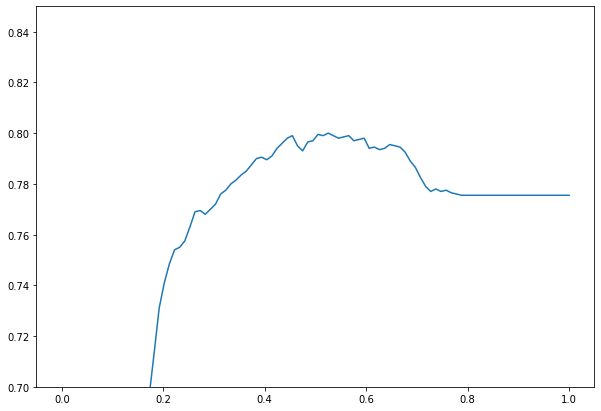

In [63]:
plt.figure(figsize=(10,7))

ax = sns.lineplot(x=threshold, y=accuracies,
                  markers=True, dashes=False)

axes = ax.axes
axes.set_ylim(0.7,0.85)


The highest point is around 0.5, not too far off from the default setting. So, I am not going to make any changes here.

---
### Confusion matrix

Confusion matrix, without normalization
[[1461   90]
 [ 313  136]]


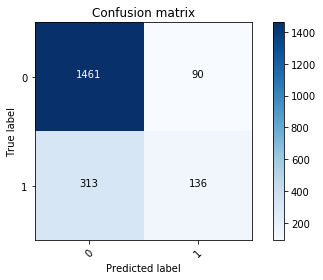

In [64]:
# Confusion matrix: where is the problem

import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cnf_matrix = confusion_matrix(labels_test, predictions)
plot_confusion_matrix(cnf_matrix,classes=[0,1])

### What are the key features?

In [72]:
import shap
shap.initjs()

explainer = shap.LinearExplainer(clf, features_train, feature_dependence="independent")
shap_values = explainer.shap_values(features_test)

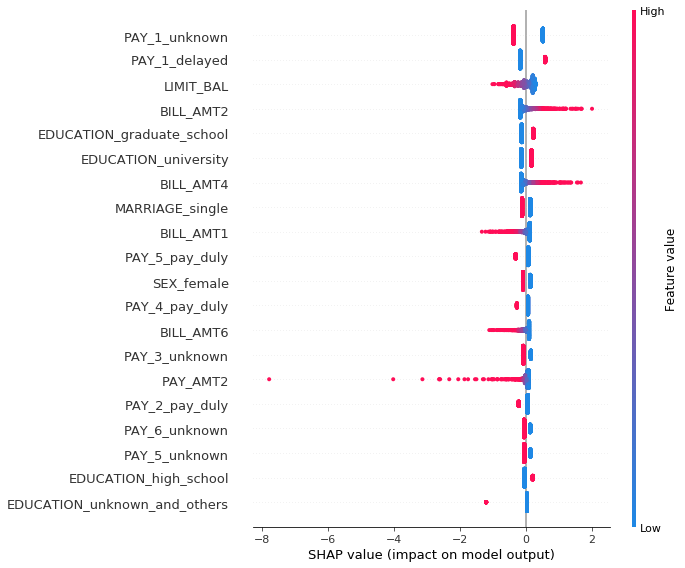

In [77]:
shap.summary_plot(shap_values, features_test, feature_names=feature_names)


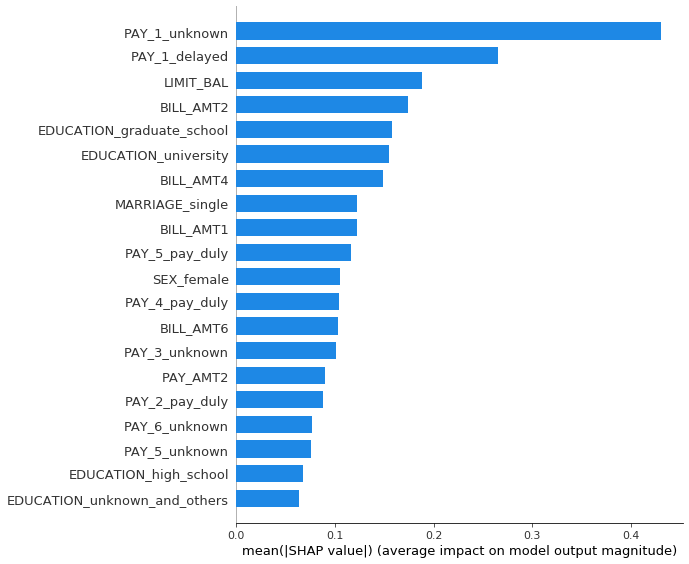

In [83]:
shap.summary_plot(shap_values, features_train, plot_type="bar",feature_names=feature_names)

In [87]:
from sklearn.feature_selection import RFE

rfe = RFE(clf, 20)
rfe = rfe.fit(features_train, labels_train)
print(rfe.support_)
print(rfe.ranking_)

[ True False False False False  True  True False False  True False False
 False False False False  True  True  True  True False  True False  True
  True  True False  True False False  True  True False  True  True  True
  True  True False False False]
[ 1 18  2  3  9  1  1 12  4  1 17 22 13 19  7  8  1  1  1  1 20  1 16  1
  1  1 10  1 21 11  1  1  6  1  1  1  1  1 14 15  5]


In [92]:
list(map(lambda x, y: x if y ==0 else '', feature_names, rfe.support_))

['',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 '',
 '',
 'BILL_AMT6',
 'PAY_AMT1',
 '',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'SEX_female',
 'SEX_male',
 '',
 '',
 '',
 '',
 'MARRIAGE_married',
 '',
 'MARRIAGE_unknown_and_others',
 '',
 '',
 '',
 'PAY_2_delayed',
 '',
 'PAY_2_unknown',
 'PAY_3_delayed',
 '',
 '',
 'PAY_4_delayed',
 '',
 '',
 '',
 '',
 '',
 'PAY_6_delayed',
 'PAY_6_pay_duly',
 'PAY_6_unknown']

### Demographic data:
Most of the features are not that useful. Age has stand out out of all of them.

### History of repayment status, payments and bill statements 
The more recent repayment status are more important than the older ones.
Similar observation can be seen in billing statement.


---
# 5. Perform feature engineering



In [229]:
df_fe = df_explore.copy()

---
### Repayment status frequency

In [230]:
select_cols = ['PAY_'+str(i) for i in range(1,7)]
df_fe['N_PAY_DULY'] = df_fe[df_fe[select_cols]=='pay_duly'].count(axis=1)
df_fe['N_DELAYED'] = df_fe[df_fe[select_cols]=='delayed'].count(axis=1)
df_fe['N_UNKNOWN'] = df_fe[df_fe[select_cols]=='unknown'].count(axis=1)


In [231]:
d_rate_by_col(df_fe, 'N_PAY_DULY')


DEFAULT_PAY,0,1,perc
N_PAY_DULY,,,
0,4911,1680,0.254893
1,607,128,0.174150
2,500,94,0.158249
3,354,79,0.182448
4,407,79,0.162551
5,395,84,0.175365
6,588,94,0.137830


In [232]:
d_rate_by_col(df_fe, 'N_DELAYED')


DEFAULT_PAY,0,1,perc
N_DELAYED,,,
0,5883,808,0.120759
1,1006,473,0.319811
2,378,253,0.400951
3,185,188,0.504021
4,138,165,0.544554
5,39,58,0.597938
6,133,293,0.687793


In [233]:
d_rate_by_col(df_fe, 'N_UNKNOWN')

DEFAULT_PAY,0,1,perc
N_UNKNOWN,,,
0,901,461,0.338473
1,457,139,0.233221
2,534,240,0.310078
3,520,253,0.327296
4,660,272,0.291845
5,955,380,0.284644
6,3735,493,0.116604


N_DELAYED seems to be quite good at flagging default user. The higher the number of months, the higher the default rate.


---
### Credit utilisation rate


In [234]:
for i in range(1,7):
    df_fe['UTILIZE_PTG'+str(i)] = df_fe['BILL_AMT'+str(i)] / df_fe['LIMIT_BAL']


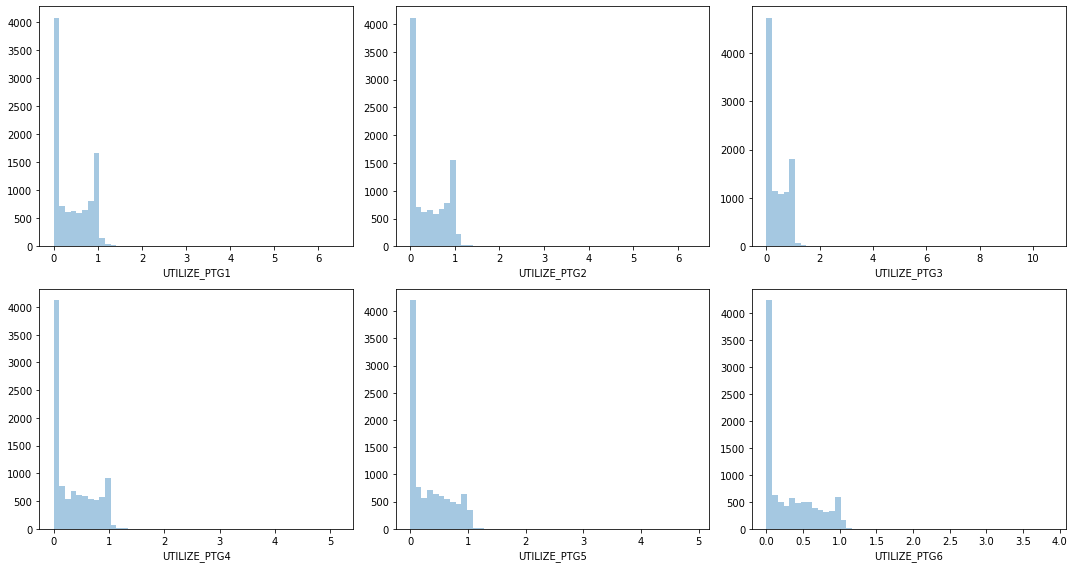

In [235]:
monthly_plot(df_fe, 'UTILIZE_PTG')


In [236]:
UTILIZE_PTG_BUCK1 = pd.qcut(df_fe['UTILIZE_PTG1'], 5)

df_temp = pd.DataFrame({'UTILIZE_PTG_BUCK1': UTILIZE_PTG_BUCK1,'DEFAULT_PAY':df_fe['DEFAULT_PAY']})

d_rate_by_col(df_temp, 'UTILIZE_PTG_BUCK1')

DEFAULT_PAY,0,1,perc
UTILIZE_PTG_BUCK1,,,
"(-0.001, 0.0114]",1552,448,0.224
"(0.0114, 0.119]",1714,286,0.143
"(0.119, 0.512]",1594,406,0.203
"(0.512, 0.894]",1444,556,0.278
"(0.894, 6.455]",1458,542,0.271


Users with utilisation rate above 50% are more likely to go default.

---

### Payment rate
Note that PAY_AMT(n) is related to BILL_AMT(n+1).

In [237]:
for i in range(1,6):
    df_fe['PAY_PTG'+str(i)] = ((df_fe['PAY_AMT'+str(i)]+0.01) / (df_fe['BILL_AMT'+str(i+1)]+0.01)).clip(upper=1)
    

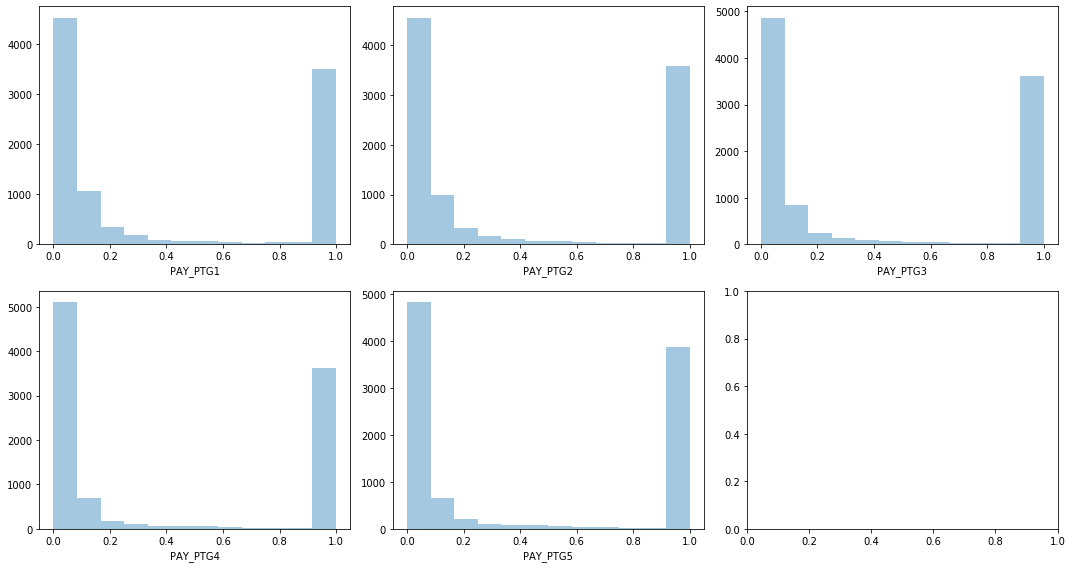

In [238]:
fig,axes = plt.subplots(2,3,figsize=(15,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i in range(0,5):
        plt.subplot(ax)
        sns.distplot(df_fe['PAY_PTG'+str(i+1)], kde=False, ax=ax)
        ax.set(xlabel='PAY_PTG'+str(i+1))

plt.tight_layout()

In [251]:
PAY_PTG_BUCK1 = pd.cut(df_fe['PAY_PTG1'],5)

df_temp = pd.DataFrame({'PAY_PTG_BUCK1': PAY_PTG_BUCK1,'DEFAULT_PAY':df_fe['DEFAULT_PAY']})

d_rate_by_col(df_temp, 'PAY_PTG_BUCK1')

DEFAULT_PAY,0,1,perc
PAY_PTG_BUCK1,,,
"(-0.001, 0.2]",4256,1518,0.262903
"(0.2, 0.4]",352,87,0.198178
"(0.4, 0.6]",129,27,0.173077
"(0.6, 0.8]",69,10,0.126582
"(0.8, 1.0]",2956,596,0.167793


Users with pay rate below 20% are more likely to go default.

---

## One-hot Encoding for categorical data


In [265]:
onehot_names = ['SEX','EDUCATION','MARRIAGE']+['PAY_'+str(i) for i in range(1,7)]
onehot_names

['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

In [268]:
df_trans = pd.get_dummies(df_fe,columns=onehot_names)
df_trans

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,PAY_3_unknown,PAY_4_delayed,PAY_4_pay_duly,PAY_4_unknown,PAY_5_delayed,PAY_5_pay_duly,PAY_5_unknown,PAY_6_delayed,PAY_6_pay_duly,PAY_6_unknown
0,1,50000.0,23,50653.0,49348.0,47995.0,40226.0,27828.0,28411.0,2190.0,...,1,0,0,1,0,0,1,0,0,1
1,2,10000.0,25,8525.0,5141.0,5239.0,7911.0,17890.0,10000.0,1500.0,...,1,0,0,1,0,0,1,0,1,0
2,3,150000.0,52,88812.0,90649.0,92499.0,94364.0,97589.0,99921.0,2564.0,...,1,0,0,1,0,0,1,0,0,1
3,4,280000.0,26,25989.0,27052.0,28111.0,29138.0,29852.0,30717.0,1800.0,...,1,0,0,1,0,0,1,0,0,1
4,5,360000.0,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,130000.0,34,23292.0,14077.0,15546.0,108047.0,93708.0,97353.0,3000.0,...,1,0,0,1,0,0,1,0,0,1
9996,9997,100000.0,35,3515.0,2975.0,2342.0,12016.0,10203.0,5323.0,10.0,...,0,0,1,0,0,0,1,0,0,1
9997,9998,280000.0,30,166037.0,166291.0,162992.0,134154.0,161057.0,167490.0,12126.0,...,1,0,0,1,0,0,1,0,0,1
9998,9999,170000.0,27,173577.0,171480.0,171794.0,166637.0,169021.0,164531.0,6500.0,...,1,0,0,1,0,0,1,0,0,1


In [269]:
df_trans.columns.values

array(['ID', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT_PAY',
       'N_PAY_DULY', 'N_DELAYED', 'N_UNKNOWN', 'UTILIZE_PTG1',
       'UTILIZE_PTG2', 'UTILIZE_PTG3', 'UTILIZE_PTG4', 'UTILIZE_PTG5',
       'UTILIZE_PTG6', 'PAY_PTG1', 'PAY_PTG2', 'PAY_PTG3', 'PAY_PTG4',
       'PAY_PTG5', 'SEX_female', 'SEX_male', 'EDUCATION_graduate_school',
       'EDUCATION_high_school', 'EDUCATION_university',
       'EDUCATION_unknown_and_others', 'MARRIAGE_married',
       'MARRIAGE_single', 'MARRIAGE_unknown_and_others', 'PAY_1_delayed',
       'PAY_1_pay_duly', 'PAY_1_unknown', 'PAY_2_delayed',
       'PAY_2_pay_duly', 'PAY_2_unknown', 'PAY_3_delayed',
       'PAY_3_pay_duly', 'PAY_3_unknown', 'PAY_4_delayed',
       'PAY_4_pay_duly', 'PAY_4_unknown', 'PAY_5_delayed',
       'PAY_5_pay_duly', 'PAY_5_unknown', 'PAY_6_delayed',
       'PAY_6_pay_duly', 

---

# 6. Select the strongest predictors

---

## Transformation

In [270]:
feature_names_raw = df_trans.columns.values
feature_names_raw = np.delete(feature_names_raw,np.argwhere(feature_names_raw=='ID'))
feature_names_raw = np.delete(feature_names_raw,np.argwhere(feature_names_raw=='DEFAULT_PAY'))
feature_names_raw

array(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'N_PAY_DULY',
       'N_DELAYED', 'N_UNKNOWN', 'UTILIZE_PTG1', 'UTILIZE_PTG2',
       'UTILIZE_PTG3', 'UTILIZE_PTG4', 'UTILIZE_PTG5', 'UTILIZE_PTG6',
       'PAY_PTG1', 'PAY_PTG2', 'PAY_PTG3', 'PAY_PTG4', 'PAY_PTG5',
       'SEX_female', 'SEX_male', 'EDUCATION_graduate_school',
       'EDUCATION_high_school', 'EDUCATION_university',
       'EDUCATION_unknown_and_others', 'MARRIAGE_married',
       'MARRIAGE_single', 'MARRIAGE_unknown_and_others', 'PAY_1_delayed',
       'PAY_1_pay_duly', 'PAY_1_unknown', 'PAY_2_delayed',
       'PAY_2_pay_duly', 'PAY_2_unknown', 'PAY_3_delayed',
       'PAY_3_pay_duly', 'PAY_3_unknown', 'PAY_4_delayed',
       'PAY_4_pay_duly', 'PAY_4_unknown', 'PAY_5_delayed',
       'PAY_5_pay_duly', 'PAY_5_unknown', 'PAY_6_delayed',
       'PAY_6_pay_duly', 'PAY_6_unknown'], dty

In [271]:
continuous_names_raw = feature_names_raw[:27]
continuous_names_raw

array(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'N_PAY_DULY',
       'N_DELAYED', 'N_UNKNOWN', 'UTILIZE_PTG1', 'UTILIZE_PTG2',
       'UTILIZE_PTG3', 'UTILIZE_PTG4', 'UTILIZE_PTG5', 'UTILIZE_PTG6',
       'PAY_PTG1', 'PAY_PTG2', 'PAY_PTG3', 'PAY_PTG4'], dtype=object)

In [272]:
categorical_names_raw = feature_names_raw[28:]
categorical_names_raw

array(['SEX_female', 'SEX_male', 'EDUCATION_graduate_school',
       'EDUCATION_high_school', 'EDUCATION_university',
       'EDUCATION_unknown_and_others', 'MARRIAGE_married',
       'MARRIAGE_single', 'MARRIAGE_unknown_and_others', 'PAY_1_delayed',
       'PAY_1_pay_duly', 'PAY_1_unknown', 'PAY_2_delayed',
       'PAY_2_pay_duly', 'PAY_2_unknown', 'PAY_3_delayed',
       'PAY_3_pay_duly', 'PAY_3_unknown', 'PAY_4_delayed',
       'PAY_4_pay_duly', 'PAY_4_unknown', 'PAY_5_delayed',
       'PAY_5_pay_duly', 'PAY_5_unknown', 'PAY_6_delayed',
       'PAY_6_pay_duly', 'PAY_6_unknown'], dtype=object)

In [273]:
# if I were to try SVM, remember to scale continuous variables before proceeding
feature_names_raw = np.concatenate((continuous_names_raw, categorical_names_raw))

---
### Split into training and testing set

In [274]:
from sklearn.model_selection import train_test_split

# split the data
df_train,df_test = train_test_split(df_onehot,test_size=0.2,random_state=2020)

In [275]:
# Check training data
d_rate = df_train.groupby(['DEFAULT_PAY']).size().reset_index(name='N_USERS')
d_rate['PTG'] = d_rate['N_USERS']/sum(d_rate['N_USERS'])
d_rate

,DEFAULT_PAY,N_USERS,PTG
0,0,6211,0.776375
1,1,1789,0.223625


In [276]:
# Check testing data
d_rate = df_test.groupby(['DEFAULT_PAY']).size().reset_index(name='N_USERS')
d_rate['PTG'] = d_rate['N_USERS']/sum(d_rate['N_USERS'])
d_rate

,DEFAULT_PAY,N_USERS,PTG
0,0,1551,0.7755
1,1,449,0.2245


---
### Fit them on Random Forest again

In [277]:
feature_names = feature_names_raw

In [278]:
# get feature and labels
features_train, features_test = \
    df_train[feature_names].values, df_test[feature_names].values
labels_train, labels_test = \
    df_train['DEFAULT_PAY'].values,df_test['DEFAULT_PAY'].values

In [279]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50],
              'max_depth':[5,10,15], 
              'min_samples_split':[30,60], 
              'min_samples_leaf':[5,10,20],
              'criterion': ['entropy', 'gini']} 
acc_scorer = make_scorer(f1_score)
grid_clf = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_clf = grid_clf.fit(features_train, labels_train)
best_clf = grid_clf.best_estimator_
print(grid_clf.best_estimator_)
print(grid_clf.best_score_)

CPU times: user 1min 28s, sys: 486 ms, total: 1min 29s
Wall time: 1min 29s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=60,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.46580375744849734


After hyper-parameter tuning, the score has only improved by about 5%.

Results (copied from above so that we don't have to re-run GridSearchCV):

- Wall time: 3min 58s
- RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=60,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
- 0.4669538460307027

In [281]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10, min_samples_split=60, min_samples_leaf=5, random_state=0)


# Train the model using the training sets
t0 = time()
clf.fit(features_train, labels_train)
training_time = round(time() - t0, 3)

# Predict the response for test dataset
t0 = time()
predictions = clf.predict(features_test)
prediction_time = round(time() - t0, 3)

# evaluate result
training_score = f1_score(y_true = labels_train, y_pred = clf.predict(features_train))
score = f1_score(y_true = labels_test, y_pred = predictions)

# Print results
print ("F1 training score:", training_score)
print ("F1 testing score:", score)
print ("Training time:", training_time, "s")
print ("Prediction time:", prediction_time, "s")

# quickly check the accuracy score as well
print ("Accuracy training score:", metrics.accuracy_score(labels_train, clf.predict(features_train)))
print ("Accuracy testing score:", metrics.accuracy_score(labels_test, predictions))

F1 training score: 0.5219251336898396
F1 testing score: 0.4503496503496504
Training time: 1.63 s
Prediction time: 0.027 s
Accuracy training score: 0.832375
Accuracy testing score: 0.8035


Confusion matrix, without normalization
[[1446  105]
 [ 288  161]]


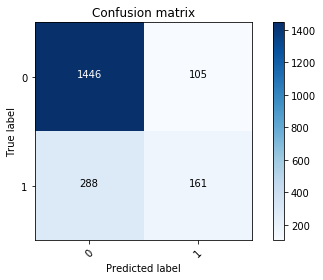

In [282]:
# Confusion matrix: where is the problem

import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cnf_matrix = confusion_matrix(labels_test, predictions)
plot_confusion_matrix(cnf_matrix,classes=[0,1])

In [ ]:
importances = clf.feature_importances_
importances

# visualize variable importance
importances = clf.feature_importances_
importances_sorted = np.argsort(importances) # sort in increasing order

plt.figure(figsize=(15,15))
plt.barh(range(importances.shape[0]), importances[importances_sorted], tick_label=np.array(feature_names)[importances_sorted.astype(int)], height=0.3)
plt.show()


---
## May be I get rid of time series features?

---
### Let's look at PAY(n)_delayed

In [283]:
feature_names =[
        'PAY_1_delayed',
        'PAY_2_delayed', 
        'PAY_3_delayed', 
        'PAY_4_delayed', 
        'PAY_5_delayed', 
        'PAY_6_delayed'
        ]


In [284]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import metrics

# get feature and labels
features_train, features_test = \
    df_train[feature_names].values, df_test[feature_names].values
labels_train, labels_test = \
    df_train['DEFAULT_PAY'].values,df_test['DEFAULT_PAY'].values

clf = RandomForestClassifier(n_estimators=50, random_state=0)

# Train the model using the training sets
t0 = time()
clf.fit(features_train, labels_train)
training_time = round(time() - t0, 3)

# Predict the response for test dataset
t0 = time()
predictions = clf.predict(features_test)
prediction_time = round(time() - t0, 3)

# evaluate result
training_score = f1_score(y_true = labels_train, y_pred = clf.predict(features_train))
score = f1_score(y_true = labels_test, y_pred = predictions)

# Print results
print ("F1 training score:", training_score)
print ("F1 testing score:", score)
print ("Training time:", training_time, "s")
print ("Prediction time:", prediction_time, "s")


# quickly check the accuracy score as well
print ("Accuracy training score:", metrics.accuracy_score(labels_train, clf.predict(features_train)))
print ("Accuracy testing score:", metrics.accuracy_score(labels_test, predictions))

F1 training score: 0.4173913043478261
F1 testing score: 0.3880597014925373
Training time: 0.137 s
Prediction time: 0.011 s
Accuracy training score: 0.807375
Accuracy testing score: 0.795


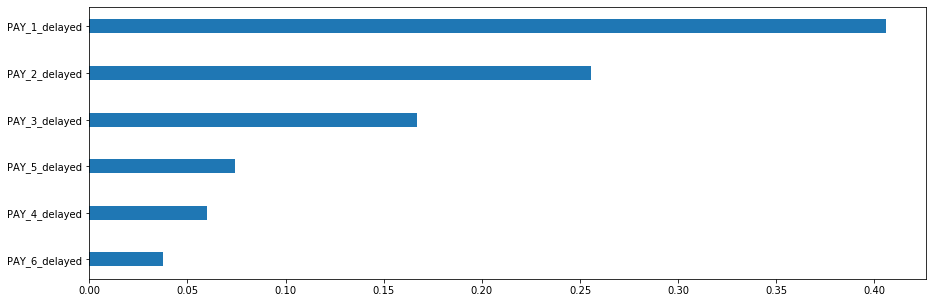

In [285]:
importances = clf.feature_importances_
importances

# visualize variable importance
importances = clf.feature_importances_
importances_sorted = np.argsort(importances) # sort in increasing order

plt.figure(figsize=(15,5))
plt.barh(range(importances.shape[0]), importances[importances_sorted], tick_label=np.array(feature_names)[importances_sorted.astype(int)], height=0.3)
plt.show()


The older the data the less important they are. Let's try to predict with only the latest data (i.e. 1).

---
### Remove older data

In [286]:
import re

r = re.compile(".*[2-6].*")

feature_names = feature_names_raw

remove_feature = []
for i in range(len(feature_names)):
    if r.search(feature_names[i]):
        remove_feature.append(i)
        print ("{} feature no.{} - {}".format(i+1, i, feature_names[i]))

print(remove_feature)

4 feature no.3 - BILL_AMT2
5 feature no.4 - BILL_AMT3
6 feature no.5 - BILL_AMT4
7 feature no.6 - BILL_AMT5
8 feature no.7 - BILL_AMT6
10 feature no.9 - PAY_AMT2
11 feature no.10 - PAY_AMT3
12 feature no.11 - PAY_AMT4
13 feature no.12 - PAY_AMT5
14 feature no.13 - PAY_AMT6
19 feature no.18 - UTILIZE_PTG2
20 feature no.19 - UTILIZE_PTG3
21 feature no.20 - UTILIZE_PTG4
22 feature no.21 - UTILIZE_PTG5
23 feature no.22 - UTILIZE_PTG6
25 feature no.24 - PAY_PTG2
26 feature no.25 - PAY_PTG3
27 feature no.26 - PAY_PTG4
40 feature no.39 - PAY_2_delayed
41 feature no.40 - PAY_2_pay_duly
42 feature no.41 - PAY_2_unknown
43 feature no.42 - PAY_3_delayed
44 feature no.43 - PAY_3_pay_duly
45 feature no.44 - PAY_3_unknown
46 feature no.45 - PAY_4_delayed
47 feature no.46 - PAY_4_pay_duly
48 feature no.47 - PAY_4_unknown
49 feature no.48 - PAY_5_delayed
50 feature no.49 - PAY_5_pay_duly
51 feature no.50 - PAY_5_unknown
52 feature no.51 - PAY_6_delayed
53 feature no.52 - PAY_6_pay_duly
54 feature no.5

In [287]:
feature_names = np.delete(feature_names,remove_feature)
feature_names

array(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1', 'N_PAY_DULY',
       'N_DELAYED', 'N_UNKNOWN', 'UTILIZE_PTG1', 'PAY_PTG1', 'SEX_female',
       'SEX_male', 'EDUCATION_graduate_school', 'EDUCATION_high_school',
       'EDUCATION_university', 'EDUCATION_unknown_and_others',
       'MARRIAGE_married', 'MARRIAGE_single',
       'MARRIAGE_unknown_and_others', 'PAY_1_delayed', 'PAY_1_pay_duly',
       'PAY_1_unknown'], dtype=object)

In [288]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import metrics

# get feature and labels
features_train, features_test = \
    df_train[feature_names].values, df_test[feature_names].values
labels_train, labels_test = \
    df_train['DEFAULT_PAY'].values,df_test['DEFAULT_PAY'].values

clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10, min_samples_split=60, min_samples_leaf=5, random_state=0)

# Train the model using the training sets
t0 = time()
clf.fit(features_train, labels_train)
training_time = round(time() - t0, 3)

# Predict the response for test dataset
t0 = time()
predictions = clf.predict(features_test)
prediction_time = round(time() - t0, 3)

# evaluate result
training_score = f1_score(y_true = labels_train, y_pred = clf.predict(features_train))
score = f1_score(y_true = labels_test, y_pred = predictions)

# Print results
print ("F1 training score:", training_score)
print ("F1 testing score:", score)
print ("Training time:", training_time, "s")
print ("Prediction time:", prediction_time, "s")


# quickly check the accuracy score as well
print ("Accuracy training score:", metrics.accuracy_score(labels_train, clf.predict(features_train)))
print ("Accuracy testing score:", metrics.accuracy_score(labels_test, predictions))

F1 training score: 0.5102823283373998
F1 testing score: 0.44846796657381616
Training time: 0.788 s
Prediction time: 0.036 s
Accuracy training score: 0.824375
Accuracy testing score: 0.802


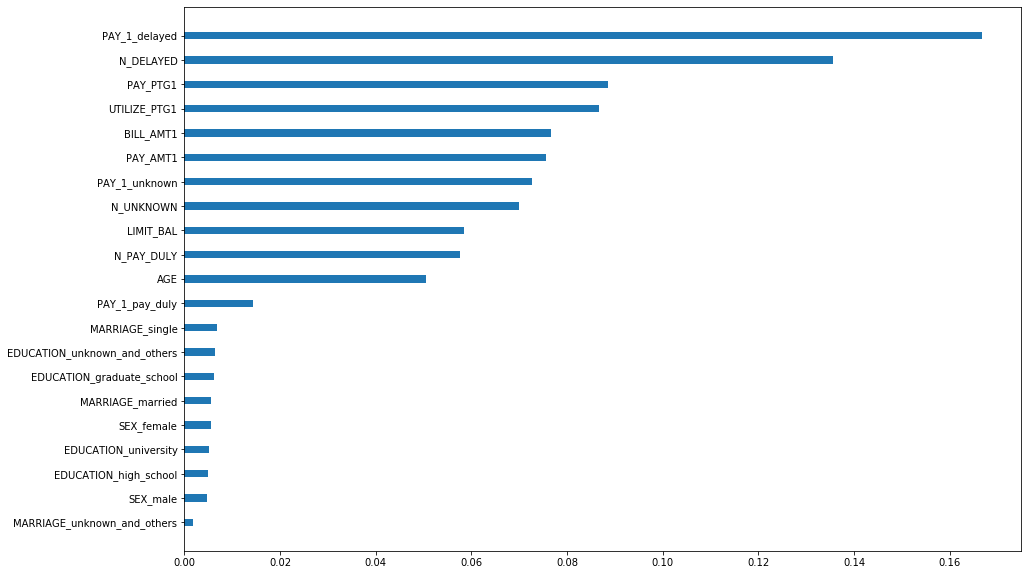

In [289]:
importances = clf.feature_importances_
importances

# visualize variable importance
importances = clf.feature_importances_
importances_sorted = np.argsort(importances) # sort in increasing order

plt.figure(figsize=(15,10))
plt.barh(range(importances.shape[0]), importances[importances_sorted], tick_label=np.array(feature_names)[importances_sorted.astype(int)], height=0.3)
plt.show()


---
### Select fewer features to treat overfitting (regularisation)


In [290]:
indices = np.argsort(importances)[::-1]
print ('Feature Ranking: ')
for i in range(10):
    print ("{} feature no.{} - {} ({})".format(i+1, indices[i], feature_names[indices[i]], importances[indices[i]]))

Feature Ranking: 
1 feature no.18 - PAY_1_delayed (0.1666731771012183)
2 feature no.5 - N_DELAYED (0.1355087075048499)
3 feature no.8 - PAY_PTG1 (0.08856870720469798)
4 feature no.7 - UTILIZE_PTG1 (0.08667214053939952)
5 feature no.2 - BILL_AMT1 (0.076736794597956)
6 feature no.3 - PAY_AMT1 (0.07561778445924777)
7 feature no.20 - PAY_1_unknown (0.07260278827322138)
8 feature no.6 - N_UNKNOWN (0.06991010523086554)
9 feature no.0 - LIMIT_BAL (0.058415245173918696)
10 feature no.4 - N_PAY_DULY (0.057515486485371116)


In [291]:
remove_feature = []
for i in range(len(importances)):
    if importances[i] < 0.03:
        remove_feature.append(i)
        print ("{} feature no.{} - {} ({})".format(i+1, indices[i], feature_names[i], importances[i]))
    
print(remove_feature)


10 feature no.4 - SEX_female (0.005528009840063108)
11 feature no.1 - SEX_male (0.004672530357338761)
12 feature no.19 - EDUCATION_graduate_school (0.006239047902842833)
13 feature no.16 - EDUCATION_high_school (0.00489603445588107)
14 feature no.14 - EDUCATION_university (0.005153211841953001)
15 feature no.11 - EDUCATION_unknown_and_others (0.00636986169421592)
16 feature no.15 - MARRIAGE_married (0.005614319801813682)
17 feature no.9 - MARRIAGE_single (0.006759759773672162)
18 feature no.13 - MARRIAGE_unknown_and_others (0.001716812568141995)
20 feature no.10 - PAY_1_pay_duly (0.014343523892073778)
[9, 10, 11, 12, 13, 14, 15, 16, 17, 19]


In [292]:
feature_names = np.delete(feature_names,remove_feature)
feature_names

array(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1', 'N_PAY_DULY',
       'N_DELAYED', 'N_UNKNOWN', 'UTILIZE_PTG1', 'PAY_PTG1',
       'PAY_1_delayed', 'PAY_1_unknown'], dtype=object)

In [293]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import metrics

# get feature and labels
features_train, features_test = \
    df_train[feature_names].values, df_test[feature_names].values
labels_train, labels_test = \
    df_train['DEFAULT_PAY'].values,df_test['DEFAULT_PAY'].values

clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10, min_samples_split=60, min_samples_leaf=5, random_state=0)

# Train the model using the training sets
t0 = time()
clf.fit(features_train, labels_train)
training_time = round(time() - t0, 3)

# Predict the response for test dataset
t0 = time()
predictions = clf.predict(features_test)
prediction_time = round(time() - t0, 3)

# evaluate result
training_score = f1_score(y_true = labels_train, y_pred = clf.predict(features_train))
score = f1_score(y_true = labels_test, y_pred = predictions)

# Print results
print ("F1 training score:", training_score)
print ("F1 testing score:", score)
print ("Training time:", training_time, "s")
print ("Prediction time:", prediction_time, "s")


# quickly check the accuracy score as well
print ("Accuracy training score:", metrics.accuracy_score(labels_train, clf.predict(features_train)))
print ("Accuracy testing score:", metrics.accuracy_score(labels_test, predictions))

F1 training score: 0.5098730606488012
F1 testing score: 0.4463276836158192
Training time: 0.909 s
Prediction time: 0.03 s
Accuracy training score: 0.82625
Accuracy testing score: 0.804
